# 자동차 파손 영역 검사 및 가격 산출 AI 만들기

### 유튜브 [빵형의 개발도상국](https://www.youtube.com/channel/UC9PB9nKYqKEx_N3KM-JVTpg)

### 도움 : [AI허브](https://www.aihub.or.kr), [쏘카](https://www.socar.kr)

In [1]:
import torch
import cv2
import matplotlib.pyplot as plt

from src.Models import Unet

## 모델 로드

- `[DAMAGE][Breakage_3]Unet.pt` : 파손
- `[DAMAGE][Crushed_2]Unet.pt` : 찌그러짐
- `[DAMAGE][Scratch_0]Unet.pt` : 스크래치
- `[DAMAGE][Seperated_1]Unet.pt` : 이격

### 사전 학습 모델 다운로드

https://drive.google.com/drive/folders/1q0l5vT14Kka_iu0WZgn1EFJLUbWD8EtY?usp=sharing

### 데이터셋

[차량 파손 이미지 - AI허브](https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=581)

In [14]:
# weight_path = 'models/[DAMAGE][Breakage_3]Unet.pt'
# weight_path = 'models/[DAMAGE][Crushed_2]Unet.pt'
weight_path = 'models/[DAMAGE][Scratch_0]Unet.pt'
# weight_path = 'models/[DAMAGE][Seperated_1]Unet.pt'

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

print('Loaded pretrained model!')

Loaded pretrained model!


## 이미지 로드

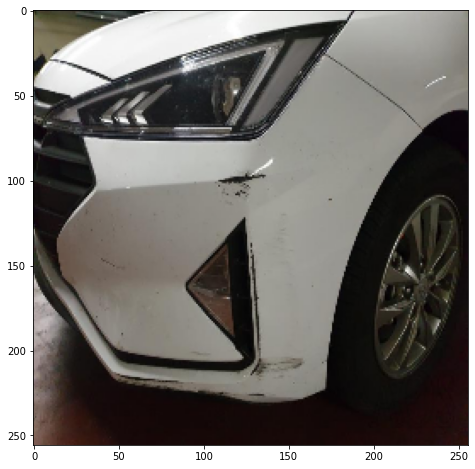

In [15]:
# img_path = 'samples/damage/0000002_as-0036229.jpg' # Breakage
img_path = 'samples/damage/0000565_sc-163434.jpg' # Scratch

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

## 이미지 전처리

In [16]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

img_input.shape

torch.Size([1, 3, 256, 256])

## 모델 추론

In [17]:
output = model(img_input)

output.shape

torch.Size([1, 2, 256, 256])

## 후처리 및 추론 마스크 시각화

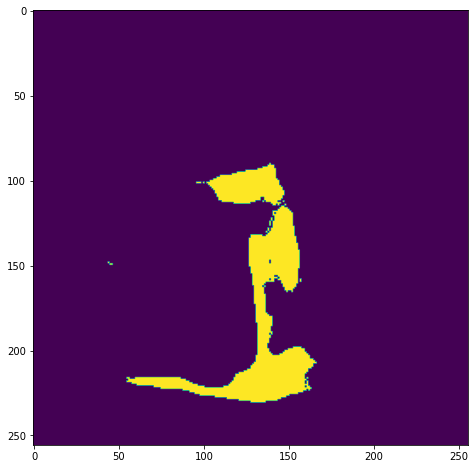

In [18]:
img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

plt.figure(figsize=(8, 8))
plt.imshow(img_output)

## 결과

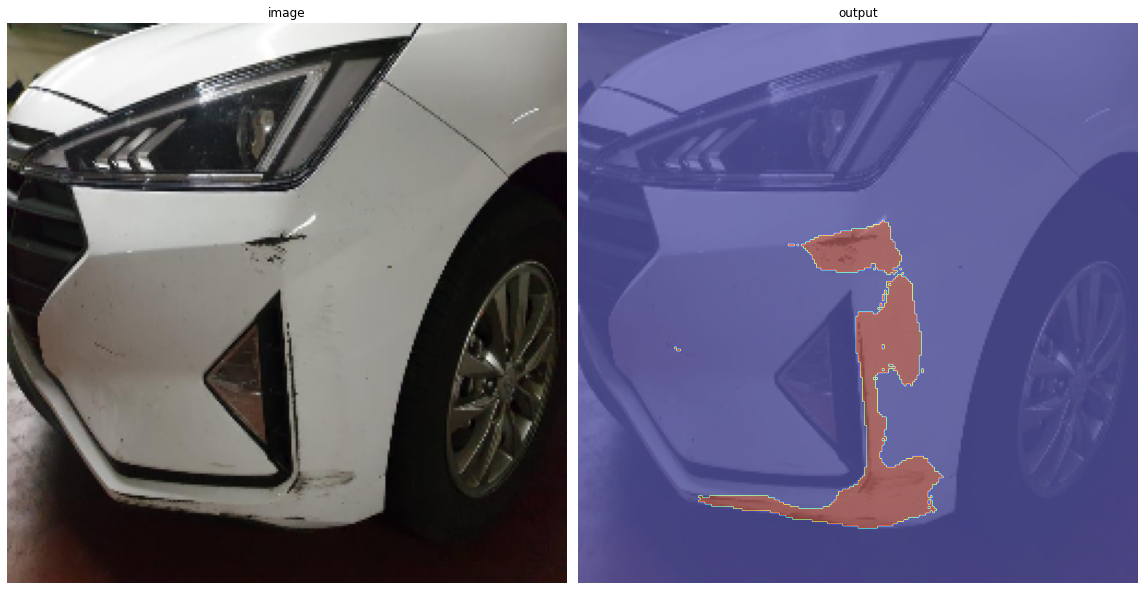

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

# 여러 형태의 파손 영역 감지

In [20]:
labels = ['Breakage_3', 'Crushed_2', 'Scratch_0', 'Seperated_1']
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for label in labels:
    model_path = f'models/[DAMAGE][{label}]Unet.pt'

    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded pretrained models!')

Loaded pretrained models!


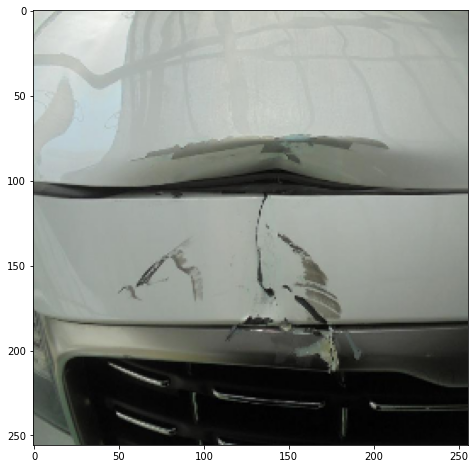

In [23]:
img_path = 'samples/damage/0000177_sc-153567.jpg'

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

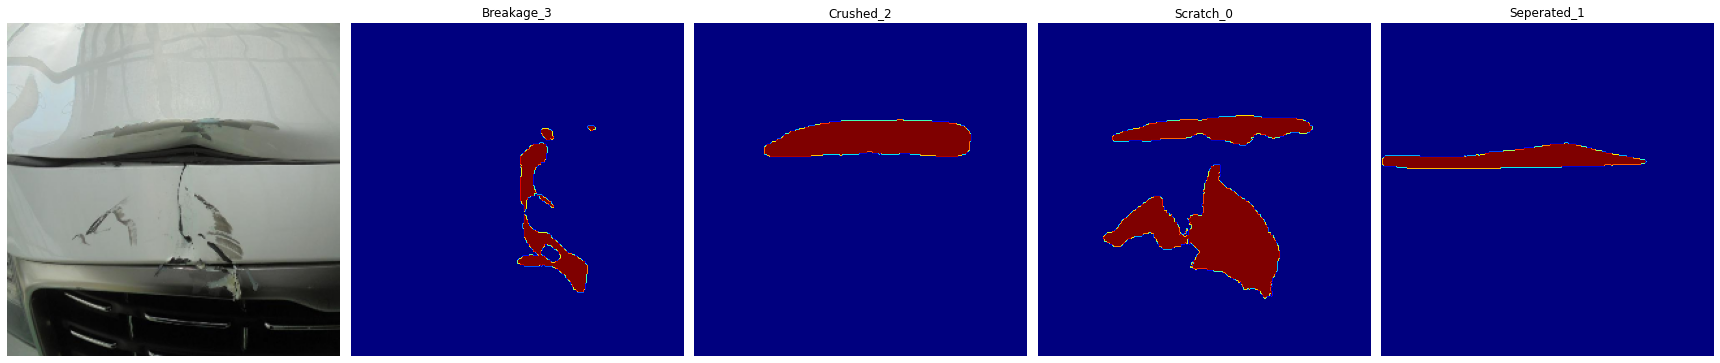

In [25]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

##  파손 영역 크기 계산

In [28]:
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage_3: 1746
Crushed_2: 3702
Scratch_0: 7407
Seperated_1: 2297


## 파손 영역 크기에 따른 가격 산출 (예시)

1픽셀당 가격을 책정하여 영역이 넓을 수록 수리비용이 비싸진다

In [32]:
price_table = [
    100, # Breakage_3
    200, # Crushed_2
    50,  # Scratch_0
    120, # Seperated_1
]

total = 0

for i, price in enumerate(price_table):
    area = outputs[i].sum()
    total += area * price

    print(f'{labels[i]}:\t영역: {area}\t가격:{area * price}원')

print(f'빵형 고객님, 총 수리비는 {total}원 입니다!')

Breakage_3:	영역: 1746	가격:174600원
Crushed_2:	영역: 3702	가격:740400원
Scratch_0:	영역: 7407	가격:370350원
Seperated_1:	영역: 2297	가격:275640원
빵형 고객님, 총 수리비는 1560990원 입니다!
